### Title: 
# Exploratory Data Analysis

### Description:
We are going to perform an EDA of our dataset.

### Authors:
#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
23/10/2020

### Version:
1.0

***

### Libraries

We are going to start this EDA loading the respective libraries

In [188]:
    # Numpy & Pandas to work with the DF
import numpy as np
import pandas as pd

    # Seaborn / matplotlib for graphs
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

    # Visualize DF
from IPython.display import display, HTML

    # Import Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

***

## Load data

In [189]:
    # To automate the work as much as possible, we will parameterize the codes, so in this case, we will create an objetct with
    # the path root
name = 'data_train_merge'

data = pd.read_csv(f'../data/02_intermediate/{name}.csv',  # Path root: here we include an f-string with the variable name to parametrize
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

***

## Variable predict

Taking into account the goals of the practice, we only want to know those persons that `Fully paid` their loans or those who does not, so we will tansform de dependent variable into binary problem, to ones or ceros depending on that condition. 

In [190]:
    # We will only select those observations with "Fully Paid" & "Charged Off"
data_binary = data[(data['loan_status'] == "Fully Paid") | (data['loan_status'] == "Charged Off")]

    # Now, we will transform into 0 & 1
dummy_dict = {"Fully Paid":0, "Charged Off":1}

    # Finally, we use the dictiony in the dataset
data = data_binary.replace({"loan_status": dummy_dict})

### View data

Firstly, we are goint to take a look to our dataframe:

In [191]:
    # First 5 rows using html display in order to view all the columns
data = data
display(HTML(data.head().to_html()))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
8,112038251,NaN,11575,11575,11575.0,36 months,7.35%,359.26,A,A4,Solutions Architect,6 years,OWN,153000.0,Not Verified,Jun-2017,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=112038251,NaN,credit_card,Credit card refinancing,923xx,CA,16.99,0,Jul-1994,720,724,0,24.0,84.0,20,1,8550,22.7%,46,w,0.0,0.0,11707.816236,11707.82,11575.0,132.82,0.0,0.0,0.0,Sep-2017,11360.38,NaN,Sep-2017,724,720,0,24.0,1,Individual,NaN,NaN,NaN,0,0,442731,1.0,1.0,0.0,0.0,27.0,92315.0,63.0,2.0,8.0,1581.0,36.0,37600,1.0,6.0,2.0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,3.0,NaN,7.0,NaN,0,6,9,9,16,12,16,32.0,9,20,0.0,0,0,2,95.7,11.1,1,0,528172,100865,28100,120572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
10,112149045,NaN,7200,7200,7200.0,36 months,24.85%,285.70,E,E3,Pse,2 years,RENT,50000.0,Source Verified,Jun-2017,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=112149045,NaN,debt_consolidation,Debt consolidation,985xx,WA,6.07,0,Jan-2000,685,689,0,72.0,NaN,4,0,3560,98.9%,5,w,0.0,0.0,7206.461000,7206.46,7200.0,6.46,0.0,0.0,0.0,Jul-2017,7231.31,NaN,Sep-2017,669,665,0,72.0,1,Individual,NaN,NaN,NaN,0,0,5588,0.0,1.0,0.0,1.0,21.0,2028.0,51.0,0.0,1.0,2779.0,74.0,3600,0.0,0.0,0.0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,14.0,NaN,14.0,NaN,1,2,2,3,3,1,3,3.0,2,4,0.0,0,0,0,80.0,100.0,0,0,7600,5588,3600,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
24,112052261,NaN,7500,7500,

In [192]:
    # Last 5 rows using html display in order to view all the columns
data = data
display(HTML(data.tail().to_html()))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
884869,36221446,NaN,11575,11575,11575.0,36 months,15.59%,404.61,D,D1,Manager,10+ years,RENT,25400.0,Verified,Jan-2015,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=36221446,NaN,credit_card,Credit card refinancing,791xx,TX,27.08,0,Jul-1999,680,684,0,NaN,NaN,9,0,18266,65%,18,f,0.0,0.0,13976.740000,13976.74,11575.00,2401.74,0.0,0.00,0.0000,Sep-2016,6281.14,NaN,Nov-2016,694,690,0,NaN,1,Individual,NaN,NaN,NaN,0,0,19798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28100,NaN,NaN,NaN,1,2200.0,9234.0,66.4,0,0,113.0,184,48,8,0,48.0,NaN,14.0,NaN,0,7,7,7,10,5,8,13.0,7,9,0.0,0,0,1,100.0,42.9,0,0,29866,19798,27500,1766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
884870,36330911,NaN,12000,12000,12000.0,36 months,11.99%,398.52,B,B5,KYC Business Analyst,< 1 year,MORTGAGE,63000.0,Verified,Jan-2015,1,n,https://lendingclub.com/browse/loanDetail.action?loan_id=36330911,NaN,credit_card,Credit card refinancing,432xx,OH,23.69,1,Jun-1995,685,689,0,9.0,NaN,13,0,21110,69.7%,61,f,0.0,0.0,5164.770000,5164.77,3847.36,1317.41,0.0,0.00,0.0000,Feb-2016,398.52,NaN,Feb-2017,629,625,0,9.0,1,Individual,NaN,NaN,NaN,0,0,237002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30300,NaN,NaN,NaN,11,18231.0,4776.0,69.0,0,0,121.0,233,1,1,1,1.0,NaN,14.0,NaN,1,4,8,4,5,40,8,20.0,8,13,0.0,0,1,3,98.3,50.0,0,0,325484,112990,15400,98125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
884873,36271333,NaN,13

In [193]:
    # Data dimension
data.shape

(442567, 151)

### Data wrangling

After studying the whole dictionary, place in `references/dictionary.md`, we saw that there are some variables that we can not use them, because is information a posteriori, some examples of these columns are: `collection_recovery_fee`, `installment`, `last_credit_pull_d`, `last_pymnt_amnt`...

In [194]:
    # First, we make an objetc with the information of these columns
columns = ["collection_recovery_fee", "dti", "dti_joint", "fico_range_high", "fico_range_low", "grade", "initial_list_status", 
           "installment", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "last_pymnt_amnt", 
           "last_pymnt_d", "loan_amnt", "mths_since_last_delinq", "mths_since_last_major_derog", "mths_since_rcnt_il", 
           "next_pymnt_d", "mths_since_recent_bc", "mths_since_recent_bc_dlq", "mths_since_recent_inq", 
           "mths_since_recent_revol_delinq", "out_prncp", "out_prncp_inv", "pymnt_plan", "recoveries", "sub_grade", 
           "tot_coll_amt", "tot_cur_bal", "total_bal_ex_mort", "total_pymnt", "total_pymnt_inv", "total_rec_int", 
           "total_rec_late_fee", "total_rec_prncp", "total_rev_hi_lim", "verification_status", "verification_status_joint",
           "issue_d", "earliest_cr_line", "hardship_flag"]

    # Then we drop those columns
data = data.drop(columns = columns)

Once we have viewed our dataset, we continue exploring the column types and nulls...

In [195]:
data.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442567 entries, 8 to 884875
Data columns (total 110 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          442567 non-null  int64  
 1   member_id                                   0 non-null       float64
 2   funded_amnt                                 442567 non-null  int64  
 3   funded_amnt_inv                             442567 non-null  float64
 4   term                                        442567 non-null  object 
 5   int_rate                                    442567 non-null  object 
 6   emp_title                                   417552 non-null  object 
 7   emp_length                                  418693 non-null  object 
 8   home_ownership                              442567 non-null  object 
 9   annual_inc                                  442567 non-null  float64


As we can see above we have plenty of columns with nulls, so we are going to drop those columns which more than a 75% of the information is null.

In [196]:
    # For this operation we will use drop.na(), but firstly we will create an objet with the scale
thresh = round(len(data) * 0.75) 

data = data.dropna(thresh = thresh, axis = 1)

    #Lets check the data shape
data.shape

(442567, 60)

We can see that now we have only 64 columns, instead of 151. This is a huge reduction of the variables, but we continue having too much, in order to reduce them, we will study which of them are important in order to predict `loan_status`.

Other method we can use in order to select those variables which are important is, we could use a correlation matrix and select those whith hight correlation values, but with 65 columns will be too difficult... so we will use a smarter way:

*Select those variables with more than 80% of correlation between them and drop them*

In [197]:
    # To start, we create our objet called "correlated_features" and our correlation parameter
correlated_features = set()
corr_param = 0.8

    # Them, we drop our predict variable
correlation_matrix = data.drop('loan_status', axis=1).corr()

    # Finally we use a loop
for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_param:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

correlated_features

{'funded_amnt_inv',
 'num_bc_sats',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bc_limit'}

In [198]:
data = data.drop(correlated_features, axis = 1)

Now we will drop those columns which are not important to predict `loan_status`, using our business knowlege, some examples of them are `url`, `policy_code`, `title`, `purpose`...

In [199]:
    # First, we make an objetc with the information of these columns
columns = ["emp_title", "id", "policy_code", "purpose", "title", "url", "zip_code"]

    # Then we drop those columns
data = data.drop(columns = columns)

    # Check the dataset
data.shape

(442567, 43)

***

***

**Vamos a ir viendo cuales son los valores únicos de cada variable e intentar pasarlas a factor, para poder practicar un RFE y un PCA, de manera que nos quedemos con las buenas...**

In [200]:
display(HTML(data.head().to_html()))

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,addr_state,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
8,11575,36 months,7.35%,6 years,OWN,153000.0,0,CA,0,0,20,1,8550,22.7%,46,0,Individual,0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,0,6,9,16,12,0.0,0,2,95.7,1,0,120572,Cash,N
10,7200,36 months,24.85%,2 years,RENT,50000.0,0,WA,0,0,4,0,3560,98.9%,5,0,Individual,0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,1,2,2,3,1,0.0,0,0,80.0,0,0,4000,Cash,N
24,7500,36 months,7.35%,7 years,MORTGAGE,110000.0,0,TX,0,2,19,0,23348,27.2%,27,0,Individual,0,13,14551.0,60352.0,27.9,0,0,48.0,51,3,3,4,0,11,11,13,8,0.0,0,3,100.0,0,0,32239,Cash,N
42,10000,60 months,16.02%,7 years,RENT,51979.0,0,CA,0,0,15,2,5733,20%,21,0,Individual,0,7,730.0,14628.0,22.2,0,0,130.0,54,6,6,0,0,3,7,8,4,0.0,0,3,100.0,2,0,5500,Cash,N
91,14000,36 months,16.02%,7 years,MORTGAGE,75000.0,0,MA,1,0,4,0,2700,90%,10,0,Individual,0,5,31911.0,300.0,90.0,0,0,109.0,97,5,5,1,0,1,1,5,3,0.0,0,3,90.0,0,0,30321,Cash,N


In [201]:
data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [202]:
data['emp_length'].unique()

array(['6 years', '2 years', '7 years', '10+ years', '3 years',
       '< 1 year', '9 years', '4 years', '1 year', '5 years', nan,
       '8 years'], dtype=object)

In [203]:
data['home_ownership'].unique()

array(['OWN', 'RENT', 'MORTGAGE', 'ANY'], dtype=object)

In [204]:
data['addr_state'].unique()

array(['CA', 'WA', 'TX', 'MA', 'NJ', 'FL', 'CT', 'MT', 'MN', 'WI', 'VA',
       'GA', 'NY', 'DC', 'MD', 'PA', 'MO', 'SC', 'NV', 'MI', 'OH', 'CO',
       'LA', 'NM', 'TN', 'IL', 'KY', 'AZ', 'IN', 'OR', 'ME', 'NC', 'OK',
       'ND', 'RI', 'ID', 'AR', 'HI', 'AL', 'MS', 'UT', 'KS', 'VT', 'NE',
       'NH', 'SD', 'DE', 'AK', 'WY', 'WV', 'IA'], dtype=object)

In [205]:
data['application_type'].unique()

array(['Individual', 'Joint App'], dtype=object)

In [206]:
data['disbursement_method'].unique()

array(['Cash', 'DirectPay'], dtype=object)

In [207]:
data['debt_settlement_flag'].unique()

array(['N', 'Y'], dtype=object)

**Primera conculsión, como solo tenemos un único tipo en `hardship_flag` la tenemos que eliminar, porque no aporta info**

**Vamos a revisar los tipos que tenemos de objetos que tenemos para ver qué cambios tenemos que hacer**

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442567 entries, 8 to 884875
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   funded_amnt                 442567 non-null  int64  
 1   term                        442567 non-null  object 
 2   int_rate                    442567 non-null  object 
 3   emp_length                  418693 non-null  object 
 4   home_ownership              442567 non-null  object 
 5   annual_inc                  442567 non-null  float64
 6   loan_status                 442567 non-null  int64  
 7   addr_state                  442567 non-null  object 
 8   delinq_2yrs                 442567 non-null  int64  
 9   inq_last_6mths              442567 non-null  int64  
 10  open_acc                    442567 non-null  int64  
 11  pub_rec                     442567 non-null  int64  
 12  revol_bal                   442567 non-null  int64  
 13  revol_util    

- `term`: Hay que quitarle "months" y pasarlo a factor, si es a 36 meses 0, si es a 60 1 **✓**

- `int_rate`: Eliminar el símbolo "%" y pasarlo a float **✓**

- `emp_length`: Factorizarlo **✓**

- `home_ownership`: Factorizarlo **✓**

- `issue_d`: Ver que hacemos con las fechas... OJO no sé si se refiere a la fecha en la que se solicitó o se concedió, si es la última hay que quitarla **✓**

- **`loan_status`**: Factorizarlo

- `addr_state`: Factorizarlo **✓**

- `earliest_cr_line`: Ver que hacemos con las fechas... Igual esta no interesa **✓**

- `revol_util`: Quitar el símbolo "%" y pasarlo a float **✓**

- `application_type`: Factorizarlo **✓**

- `hardship_flag`: Cargarsela porque solo tiene un tipo **✓**

- `disbursement_method`: Factorizarla **✓**

- `debt_settlement_flag`: Factorizarla **✓**

In [209]:
display(HTML(data.head().to_html()))

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,addr_state,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
8,11575,36 months,7.35%,6 years,OWN,153000.0,0,CA,0,0,20,1,8550,22.7%,46,0,Individual,0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,0,6,9,16,12,0.0,0,2,95.7,1,0,120572,Cash,N
10,7200,36 months,24.85%,2 years,RENT,50000.0,0,WA,0,0,4,0,3560,98.9%,5,0,Individual,0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,1,2,2,3,1,0.0,0,0,80.0,0,0,4000,Cash,N
24,7500,36 months,7.35%,7 years,MORTGAGE,110000.0,0,TX,0,2,19,0,23348,27.2%,27,0,Individual,0,13,14551.0,60352.0,27.9,0,0,48.0,51,3,3,4,0,11,11,13,8,0.0,0,3,100.0,0,0,32239,Cash,N
42,10000,60 months,16.02%,7 years,RENT,51979.0,0,CA,0,0,15,2,5733,20%,21,0,Individual,0,7,730.0,14628.0,22.2,0,0,130.0,54,6,6,0,0,3,7,8,4,0.0,0,3,100.0,2,0,5500,Cash,N
91,14000,36 months,16.02%,7 years,MORTGAGE,75000.0,0,MA,1,0,4,0,2700,90%,10,0,Individual,0,5,31911.0,300.0,90.0,0,0,109.0,97,5,5,1,0,1,1,5,3,0.0,0,3,90.0,0,0,30321,Cash,N


In [210]:
    # Pasamos a cateogry la variable
data["term"] = data["term"].astype('category')
    # Comprobamos
data.term.dtypes

CategoricalDtype(categories=[' 36 months', ' 60 months'], ordered=False)

In [211]:
    # Machacamos la columna con 1 y 0
data["term"] = data["term"].cat.codes

    # Comprobamos el resultado
display(HTML(data.head().to_html()))

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,addr_state,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
8,11575,0,7.35%,6 years,OWN,153000.0,0,CA,0,0,20,1,8550,22.7%,46,0,Individual,0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,0,6,9,16,12,0.0,0,2,95.7,1,0,120572,Cash,N
10,7200,0,24.85%,2 years,RENT,50000.0,0,WA,0,0,4,0,3560,98.9%,5,0,Individual,0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,1,2,2,3,1,0.0,0,0,80.0,0,0,4000,Cash,N
24,7500,0,7.35%,7 years,MORTGAGE,110000.0,0,TX,0,2,19,0,23348,27.2%,27,0,Individual,0,13,14551.0,60352.0,27.9,0,0,48.0,51,3,3,4,0,11,11,13,8,0.0,0,3,100.0,0,0,32239,Cash,N
42,10000,1,16.02%,7 years,RENT,51979.0,0,CA,0,0,15,2,5733,20%,21,0,Individual,0,7,730.0,14628.0,22.2,0,0,130.0,54,6,6,0,0,3,7,8,4,0.0,0,3,100.0,2,0,5500,Cash,N
91,14000,0,16.02%,7 years,MORTGAGE,75000.0,0,MA,1,0,4,0,2700,90%,10,0,Individual,0,5,31911.0,300.0,90.0,0,0,109.0,97,5,5,1,0,1,1,5,3,0.0,0,3,90.0,0,0,30321,Cash,N


Next, we will convert int rate variable dropping the % symbol 

In [212]:
data['int_rate'] = data['int_rate'].apply(lambda x: float(x[:-1]))

In [213]:
# Pasamos a cateogry la variable
data["revol_util"] = data["revol_util"].astype('category') #pasamos a categorica primero
data['revol_util'] = data['revol_util'].apply(lambda x: float(x[:-1])) #sacamos el simbolo del %

In [214]:
    # Comprobamos el resultado
display(HTML(data.head().to_html()))

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,addr_state,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
8,11575,0,7.35,6 years,OWN,153000.0,0,CA,0,0,20,1,8550,22.7,46,0,Individual,0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,0,6,9,16,12,0.0,0,2,95.7,1,0,120572,Cash,N
10,7200,0,24.85,2 years,RENT,50000.0,0,WA,0,0,4,0,3560,98.9,5,0,Individual,0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,1,2,2,3,1,0.0,0,0,80.0,0,0,4000,Cash,N
24,7500,0,7.35,7 years,MORTGAGE,110000.0,0,TX,0,2,19,0,23348,27.2,27,0,Individual,0,13,14551.0,60352.0,27.9,0,0,48.0,51,3,3,4,0,11,11,13,8,0.0,0,3,100.0,0,0,32239,Cash,N
42,10000,1,16.02,7 years,RENT,51979.0,0,CA,0,0,15,2,5733,20.0,21,0,Individual,0,7,730.0,14628.0,22.2,0,0,130.0,54,6,6,0,0,3,7,8,4,0.0,0,3,100.0,2,0,5500,Cash,N
91,14000,0,16.02,7 years,MORTGAGE,75000.0,0,MA,1,0,4,0,2700,90.0,10,0,Individual,0,5,31911.0,300.0,90.0,0,0,109.0,97,5,5,1,0,1,1,5,3,0.0,0,3,90.0,0,0,30321,Cash,N


In [215]:
# Pasamos a category las variables
columns_categ = ["emp_length", "home_ownership", "loan_status", "addr_state", "application_type",
                 "disbursement_method", "debt_settlement_flag"]

data[columns_categ] = data[columns_categ].astype('category')


In [216]:

data["emp_length"] = data["emp_length"].cat.codes
data["home_ownership"] = data["home_ownership"].cat.codes
data["addr_state"] = data["addr_state"].cat.codes
data["application_type"] = data["application_type"].cat.codes
data["disbursement_method"] = data["disbursement_method"].cat.codes
data["debt_settlement_flag"] = data["debt_settlement_flag"].cat.codes

In [217]:
data.shape

(442567, 43)

In [218]:
data = data.dropna()

In [219]:
from random import sample

In [220]:
minidata = data.sample(n=1000,replace=True, random_state = 1322)
print(minidata)

        funded_amnt  term  int_rate  emp_length  home_ownership  annual_inc  \
198946         1200     0     14.08           1               3     35000.0   
341890         4200     0     23.43           0               3     40000.0   
293645        19000     0      6.03           3               1     72000.0   
266331         6000     0     15.61           3               3     65000.0   
423231        13000     0     12.99           7               3     62200.0   
...             ...   ...       ...         ...             ...         ...   
782377        12000     1     13.99           0               3     54000.0   
451259         8000     0     22.40          10               3     24725.0   
575347         7975     0     17.57           1               3     36000.0   
792652        15600     0     10.99           7               2    114000.0   
827526        20000     0     10.99           1               3     67000.0   

       loan_status  addr_state  delinq_2yrs  inq_la

In [221]:
minidata.shape

(1000, 43)

In [222]:
data2 = data.head(500)
data2

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,addr_state,delinq_2yrs,inq_last_6mths,...,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
8,11575,0,7.35,6,2,153000.0,0,4,0,0,...,12,0.0,0,2,95.7,1,0,120572,0,0
10,7200,0,24.85,2,3,50000.0,0,47,0,0,...,1,0.0,0,0,80.0,0,0,4000,0,0
24,7500,0,7.35,7,1,110000.0,0,43,0,2,...,8,0.0,0,3,100.0,0,0,32239,0,0
42,10000,1,16.02,7,3,51979.0,0,4,0,0,...,4,0.0,0,3,100.0,2,0,5500,0,0
91,14000,0,16.02,7,1,75000.0,0,19,1,0,...,3,0.0,0,3,90.0,0,0,30321,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8626,4000,0,9.93,1,3,25000.0,0,22,0,0,...,6,0.0,0,2,100.0,0,0,21670,0,0
8651,5000,0,9.44,2,3,38000.0,0,27,0,0,...,2,0.0,0,3,100.0,0,0,13999,0,0
8717,14000,1,9.93,6,1,60000.0,0,37,0,0,...,6,0.0,0,1,100.0,0,0,60724,0,0
8726,35000,0,14.08,1,1,96000.0,0,44,0,0,...,10,0.0,0,1,96.8,0,0,21577,0,0


**Una vez arreglemos todo lo de arriba podemos utilizar RFE para seleccionar las más importantes**

In [223]:
X = minidata.drop('loan_status', axis=1)
target = minidata['loan_status']

In [224]:
rfc = RandomForestClassifier(random_state=1322)

In [225]:
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=1322), scoring='accuracy')

Once the execution finishes, you can use this line of code to see how many features are optimal to produce the best accuracy (or whatever your chosen metric is):

In [226]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 30


Not only this, but you can also plot the accuracy obtained with every number of features used:

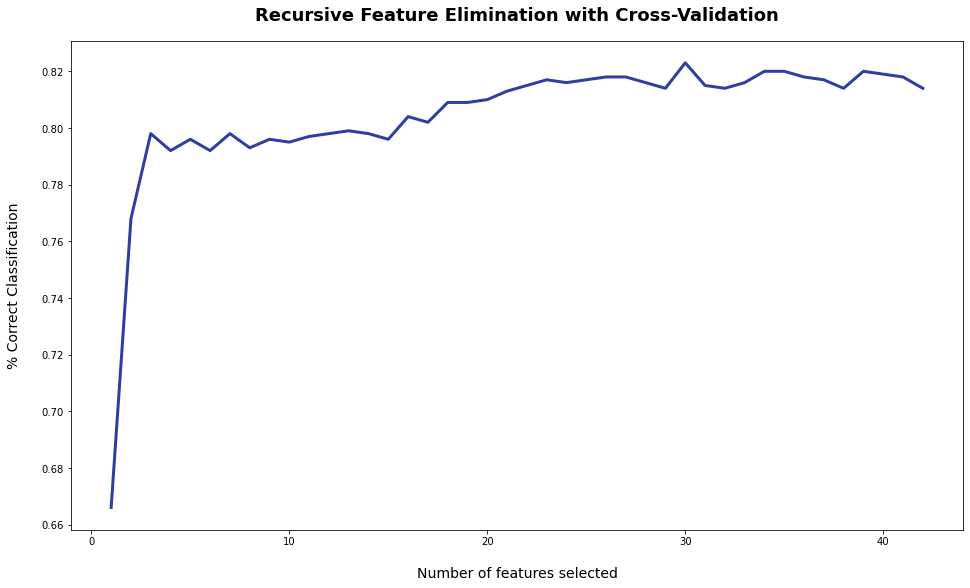

In [227]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

It is visible that with 7 features the accuracy was more than 80%, which is very good taking account that we initially have 150 variables. As we can see in the graph we could also work with 17 variables reaching almost the same score.

You can also print out which features are considered to be least important and drop them with this snippet:

In [228]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 7 10 14 15 16 21 22 33 34 37 38 40]


The instance of RFECV has also a nifty feature_importances attribute which is worthy to be checked out

In [229]:
rfecv.estimator_.feature_importances_

array([0.04460678, 0.03884873, 0.07336941, 0.02758814, 0.0158777 ,
       0.0421063 , 0.03588364, 0.0159047 , 0.02772948, 0.03534728,
       0.04515875, 0.03394621, 0.02203621, 0.05025484, 0.03906354,
       0.03954572, 0.04670001, 0.04496389, 0.0284137 , 0.02572513,
       0.01855125, 0.01157488, 0.02387968, 0.0251446 , 0.02677714,
       0.03085123, 0.02164652, 0.02562304, 0.04941114, 0.03347039])

In [230]:
features_important = rfecv.estimator_.feature_importances_


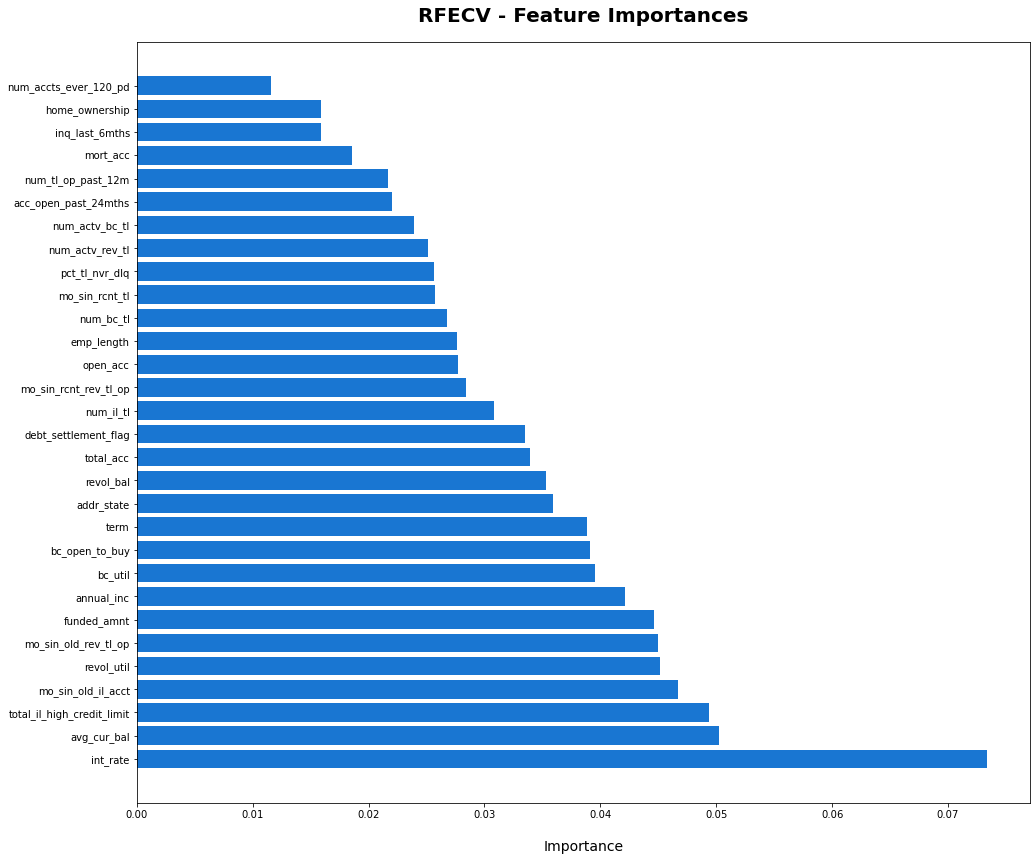

In [231]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()